# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_82100\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4615.02,1.00,-131.89,2430.08,2298.19
OMUSDT,526.32,3237.35,0.70,0.00,2711.03,2711.03
BTCUSDT,601.02,726.41,0.16,3.54,125.39,128.93
SOLUSDT,281.20,222.07,0.05,0.00,-59.13,-59.13
JASMYUSDT,387.46,170.91,0.04,0.00,-216.55,-216.55
ETHUSDT,250.75,131.61,0.03,0.00,-119.14,-119.14
TRXUSDT,76.87,111.45,0.02,-10.72,34.58,23.86
BBUSDT,60.18,14.14,0.00,-39.73,-46.03,-85.76
BNBUSDT,1.14,1.08,0.00,-10.61,-0.07,-10.68
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

473

In [20]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [21]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [22]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [23]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [24]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [25]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [27]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [28]:
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [29]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [30]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [31]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [32]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [33]:
# pnl_history['Total']

In [34]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [35]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [36]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [37]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [38]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-03-13    1981.620537
2025-03-14    2010.574081
2025-03-15    2202.769914
2025-03-16    2210.019473
2025-03-17    2485.773076
Name: Total, Length: 176, dtype: float64

In [39]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-03-13   -137.783248
2025-03-14     28.953544
2025-03-15    192.195833
2025-03-16      7.249559
2025-03-17    275.753603
Name: Total, Length: 176, dtype: float64

In [40]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,5)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-219.6118751223521, -334.9272908594338)

In [41]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [42]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [43]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [44]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [45]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [46]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [47]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

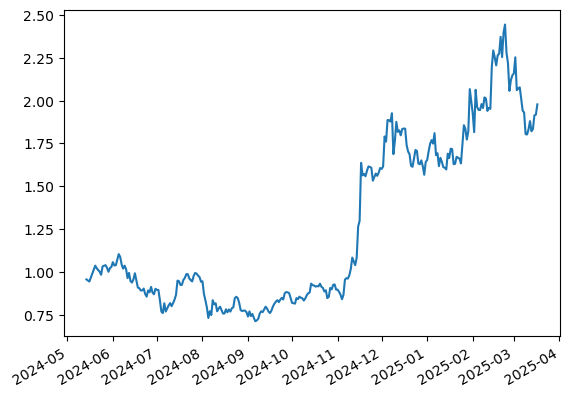

In [48]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

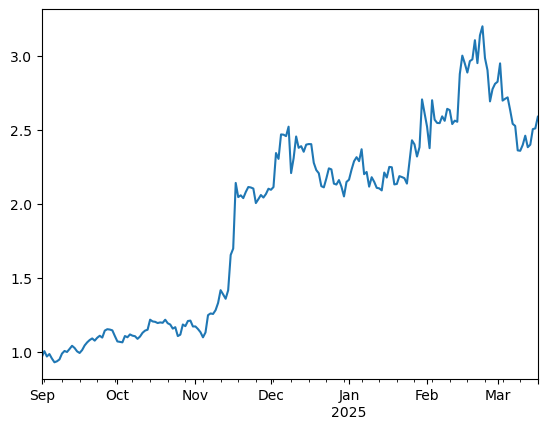

In [49]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [51]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [54]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [55]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [58]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.7764
OMUSDT,0.1369
BNBUSDT,0.0378
AAVEUSDT,0.0350
DEXEUSDT,0.0077
ADAUSDT,0.0062
PEPEUSDT,0.0000
TRXUSDT,0.0000
SUIUSDT,0.0000
BTCUSDT,0.0000


In [59]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.467102
BTCUSDT,0.300000
OMUSDT,0.232898


In [60]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

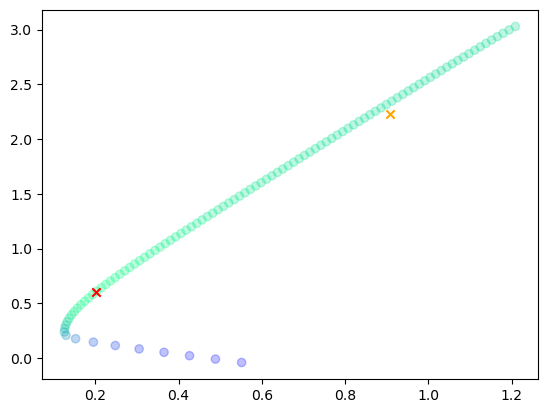

In [61]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [62]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [63]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3237.346922,0.701481,0.0638,0.637681
BTCUSDT,726.412191,0.157402,0.0000,0.157402
SOLUSDT,222.068658,0.048119,0.0000,0.048119
JASMYUSDT,170.913168,0.037034,0.0000,0.037034
ETHUSDT,131.610099,0.028518,0.0000,0.028518
TRXUSDT,111.445165,0.024148,0.0028,0.021348
BBUSDT,14.144082,0.003065,0.0000,0.003065
BNBUSDT,1.076966,0.000233,0.0689,-0.068667
PEPEUSDT,0.000002,0.000000,0.0029,-0.002900
PAXGUSDT,0.000000,0.000000,0.3989,-0.398900


### Current results

In [65]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [66]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.878819
OMUSDT,0.104344
TRXUSDT,0.016836


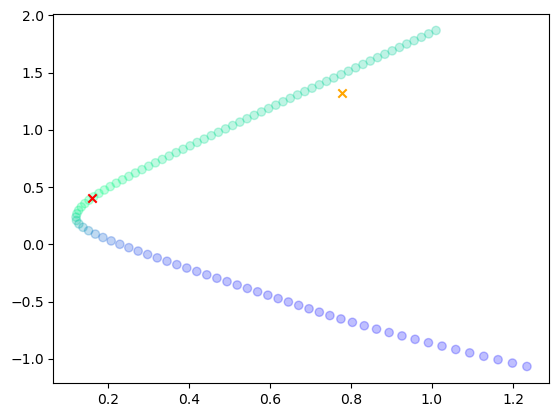

In [67]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [68]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3237.346922,0.701481,0.104344,0.597137
BTCUSDT,726.412191,0.157402,0.000000,0.157402
SOLUSDT,222.068658,0.048119,0.000000,0.048119
JASMYUSDT,170.913168,0.037034,0.000000,0.037034
ETHUSDT,131.610099,0.028518,0.000000,0.028518
TRXUSDT,111.445165,0.024148,0.016836,0.007312
BBUSDT,14.144082,0.003065,0.000000,0.003065
BNBUSDT,1.076966,0.000233,0.000000,0.000233
PEPEUSDT,0.000002,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.878819,-0.878819


# Risk Reward Analysis

In [70]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [71]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

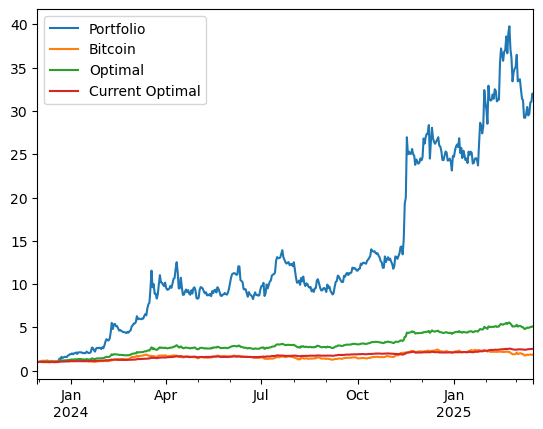

In [72]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [73]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

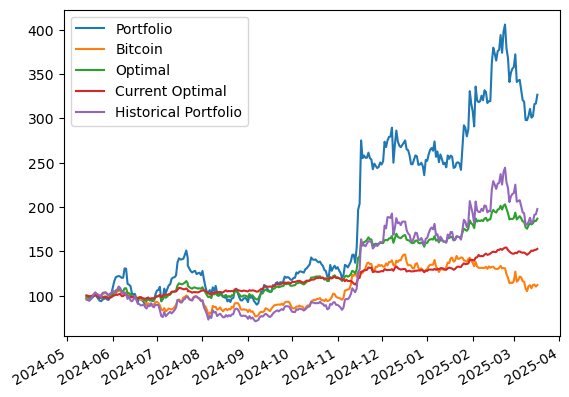

In [74]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [75]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-03-08,318.864979,115.682157,183.439747,148.744981,193.005673
2025-03-09,298.219995,108.074181,177.304781,147.606075,180.399004
2025-03-10,297.990552,105.172891,175.544166,146.161951,180.191407
2025-03-11,302.826009,110.822138,179.340105,147.446099,183.215484
2025-03-12,310.753904,111.816046,181.833495,148.910145,187.971314
2025-03-13,300.860853,108.335893,180.375914,150.935775,182.047066
2025-03-14,302.639009,112.099402,181.668795,150.446961,183.335317
2025-03-15,316.098799,112.572571,184.476105,151.594453,191.350939
2025-03-16,316.824428,110.193184,184.149761,151.758067,191.748673
2025-03-17,326.683860,112.092354,186.899400,152.862560,197.754476


## Volatilities

In [77]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.355916
 dtype: float64,
 0.3562821287407887)

In [78]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.777762
 dtype: float64,
 0.7777619423448469)

In [79]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.907415
Bitcoin            0.433904
Optimal            0.356282
Current Optimal    0.176721
dtype: float64

In [80]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4690606667707048

In [81]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-1.752710191502707

In [82]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.7020319899372454

## Risk Contribution

In [84]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.247167,0.300000,0.02698,0.231881,0.133488,0.098393
OMUSDT,18.803420,0.232898,0.93867,0.723409,0.624295,0.099114
PAXGUSDT,0.229518,0.467102,0.03435,0.044710,0.028580,0.016130


In [85]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.474145,0.104344,0.330356,0.483898,0.434068,0.049829
TRXUSDT,0.005573,0.016836,0.012797,0.020577,0.006798,0.013779
PAXGUSDT,0.271390,0.878819,0.656847,0.495526,0.455377,0.040149


In [86]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.180840,0.70,0.933972,0.894616,0.826267,0.068349
BTCUSDT,0.027693,0.16,0.045171,0.041878,0.007373,0.034506
SOLUSDT,-0.019835,0.05,0.007260,0.023988,0.002232,0.021756
JASMYUSDT,-0.025843,0.04,0.003407,0.024915,0.003204,0.021710
ETHUSDT,-0.014277,0.03,0.003784,0.009223,0.000497,0.008726
TRXUSDT,0.006620,0.02,0.006406,0.005381,0.000406,0.004975


# Value At Risk

## Historical

### Optimal Weights

In [90]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.028524765411833332, -0.040147484263141076)

### Current Weights

In [92]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05629769177910666, -0.08214405943169349)

In [93]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [94]:
var=historical_var.iloc[row]
var

OMUSDT      -0.044789
BTCUSDT     -0.006831
SOLUSDT     -0.001492
JASMYUSDT   -0.002165
ETHUSDT     -0.002305
TRXUSDT      0.000143
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.057438
Name: 2024-08-04 00:00:00, dtype: float64

In [95]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.066833
BTCUSDT     -0.005744
SOLUSDT     -0.003678
JASMYUSDT   -0.003561
ETHUSDT     -0.001699
TRXUSDT     -0.000628
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.082144
dtype: float64

## Parametric

### Optimal Weights

In [98]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.03691654296371186, -0.0473168012206383)

### Current Weights

In [100]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.08058861178805575, -0.10329231879515124)

## Multivariate

### Optimal Weights

In [103]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03286473172936995, -0.04220671798063817)

### Current Weights

In [105]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07499723884852806, -0.09521032701181935)

In [106]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

OMUSDT      -0.068022
BTCUSDT     -0.002592
SOLUSDT     -0.001687
JASMYUSDT   -0.001734
ETHUSDT     -0.000525
TRXUSDT     -0.000601
Portfolio   -0.075162
dtype: float64

In [107]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

OMUSDT      -0.068974
BTCUSDT     -0.002862
SOLUSDT     -0.001508
JASMYUSDT   -0.001663
ETHUSDT     -0.000509
TRXUSDT     -0.000549
Portfolio   -0.076065
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [111]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.032743371701005726, -0.04151478793805189)

### Current Weights

In [113]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07713295734506397, -0.09623484915343838)

In [114]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [117]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.033972699613310446, -0.043255060957673265)

### Current Weights

In [119]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07669062969158777, -0.09820493566224234)

In [120]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [123]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06655400849765096, -0.09317267956950556)

### Current Weights

In [125]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.15949212363585577, -0.23098409539769085)

In [126]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [129]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [130]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03742621619348136, -0.046124230188033896)

### Current Weights

In [132]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08300682692944851, -0.10238021569182769)

In [133]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [134]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.156319,-0.066825,-0.074404,-0.068022,-0.069523
BTCUSDT,-0.001218,-0.003539,-0.003030,-0.002592,-0.002808
SOLUSDT,0.000125,-0.002038,-0.002003,-0.001687,-0.001793
JASMYUSDT,-0.001179,-0.001851,-0.001808,-0.001734,-0.001622
ETHUSDT,-0.000118,-0.000952,-0.000617,-0.000525,-0.000675
TRXUSDT,0.000221,-0.000259,-0.000260,-0.000601,-0.000188
Portfolio,-0.158488,-0.075463,-0.082122,-0.075162,-0.076609


In [135]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.160004,-0.065940,-0.073699,-0.068974,-0.071113
BTCUSDT,-0.000073,-0.004313,-0.003415,-0.002862,-0.002604
SOLUSDT,0.000271,-0.002545,-0.002255,-0.001508,-0.001586
JASMYUSDT,-0.000944,-0.002285,-0.002363,-0.001663,-0.001433
ETHUSDT,-0.000234,-0.001047,-0.000750,-0.000509,-0.000598
TRXUSDT,0.000317,-0.000122,-0.000446,-0.000549,-0.000110
Portfolio,-0.160667,-0.076251,-0.082929,-0.076065,-0.077444


## VaR Violation

In [137]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.028973,-0.054401,-0.047720,-0.011884
2024-01-15,-0.028973,-0.054405,-0.045392,0.012410
2024-01-16,-0.028973,-0.054467,-0.043364,0.025103
2024-01-17,-0.028973,-0.055850,-0.045700,-0.019929
2024-01-18,-0.028973,-0.056751,-0.049547,-0.015648
...,...,...,...,...
2025-03-14,-0.038945,-0.046508,-0.047254,0.007168
2025-03-15,-0.038945,-0.046999,-0.047695,0.015453
2025-03-16,-0.038945,-0.043480,-0.044876,-0.001769
2025-03-17,-0.038945,-0.043427,-0.044808,0.014932


In [138]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.045379,-0.084160,-0.084169,-0.015006
2024-05-29,-0.045379,-0.082059,-0.080553,-0.007208
2024-05-30,-0.045379,-0.072331,-0.073618,0.025761
2024-05-31,-0.045379,-0.076553,-0.071739,0.049656
2024-06-01,-0.045379,-0.083514,-0.074911,0.067499
...,...,...,...,...
2025-03-14,-0.081193,-0.078726,-0.088822,0.005910
2025-03-15,-0.081193,-0.084282,-0.091871,0.044475
2025-03-16,-0.081193,-0.084114,-0.090948,0.002296
2025-03-17,-0.081193,-0.082356,-0.092069,0.031120


<Axes: >

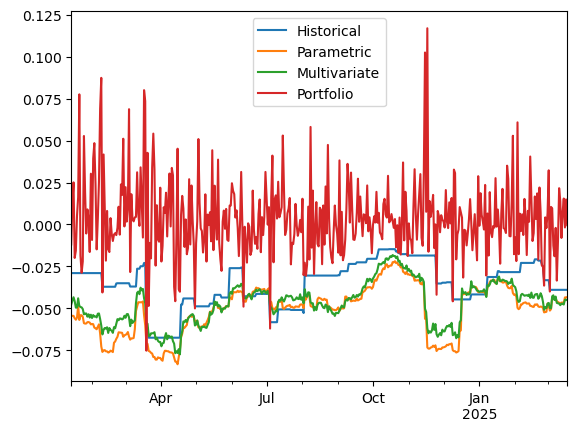

In [139]:
var_data.plot()

<Axes: >

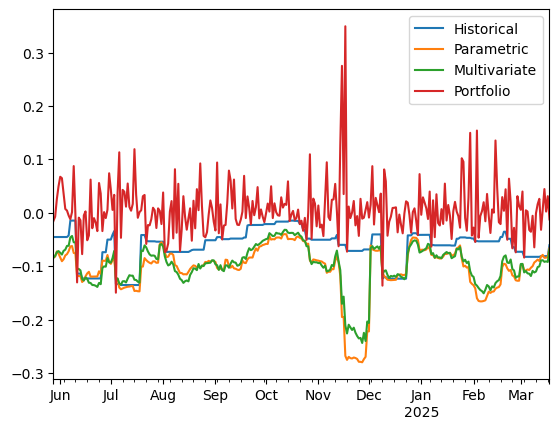

In [140]:
current_var_data.plot()

In [141]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032558,0.006977,0.006977
Kupiec Stat,3.124987,26.008809,26.008809
P-value,0.0771,0.0,0.0


In [142]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064407,0.010169,0.010169
Kupiec Stat,1.186224,14.430112,14.430112
P-value,0.276093,0.000145,0.000145


# Principal Component Analysis

## Historical PCA

In [145]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.8119443 , 0.05656196, 0.0497302 , 0.04663413, 0.03512941])

In [146]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.017609
ADAUSDT      0.019005
ALGOUSDT     0.020041
APTUSDT      0.017730
ARBUSDT      0.019362
ATOMUSDT     0.017523
AVAXUSDT     0.019529
BCHUSDT      0.015597
BNBUSDT      0.009152
BONKUSDT     0.024010
BTCUSDT      0.009890
CAKEUSDT     0.018362
DEXEUSDT     0.013639
DOGEUSDT     0.018818
DOTUSDT      0.018053
EOSUSDT      0.018326
ETCUSDT      0.016405
ETHUSDT      0.013493
FDUSDUSDT    0.000051
FETUSDT      0.023007
FILUSDT      0.019867
FLOWUSDT     0.019280
GALAUSDT     0.023454
GRTUSDT      0.021641
HBARUSDT     0.018953
ICPUSDT      0.017873
IMXUSDT      0.019983
INJUSDT      0.020995
IOTAUSDT     0.021275
JASMYUSDT    0.021304
LDOUSDT      0.020673
LINKUSDT     0.017819
LTCUSDT      0.013350
MKRUSDT      0.013098
NEARUSDT     0.021583
NEXOUSDT     0.011544
OMUSDT       0.010943
OPUSDT       0.019893
PAXGUSDT     0.000257
PEPEUSDT     0.024531
QNTUSDT      0.015581
SANDUSDT     0.021540
SEIUSDT      0.021275
SHIBUSDT     0.018386
SOLUSDT      0.016469
STXUSDT   

<Axes: >

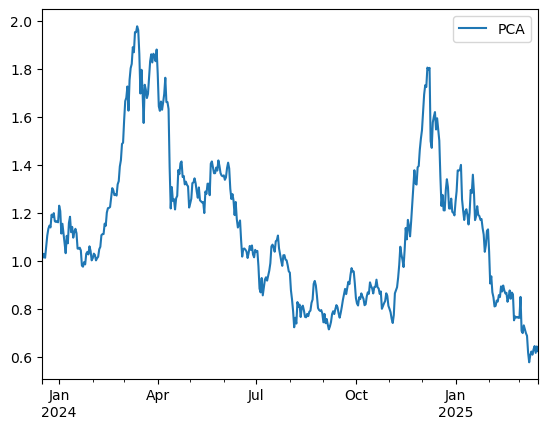

In [147]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

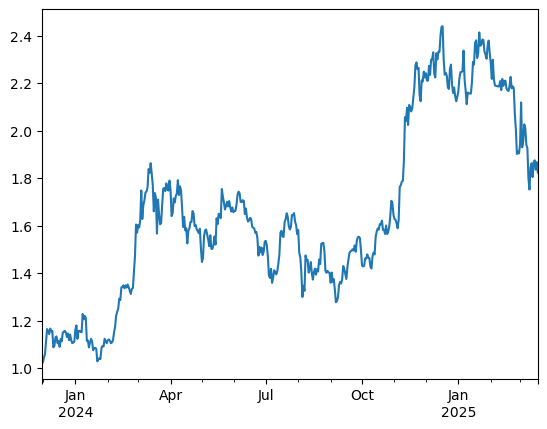

In [148]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [149]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.425883
WBETHUSDT    0.461561
ETHUSDT      0.461967
ATOMUSDT     0.474891
DOTUSDT      0.477541
ETCUSDT      0.490141
NEXOUSDT     0.515347
EOSUSDT      0.528771
AVAXUSDT     0.548049
BTCUSDT      0.550831
WBTCUSDT     0.550870
FILUSDT      0.565559
IOTAUSDT     0.567285
ARBUSDT      0.580664
GRTUSDT      0.582291
XTZUSDT      0.583218
LINKUSDT     0.609487
VETUSDT      0.612116
IMXUSDT      0.623180
dtype: float64

<Axes: >

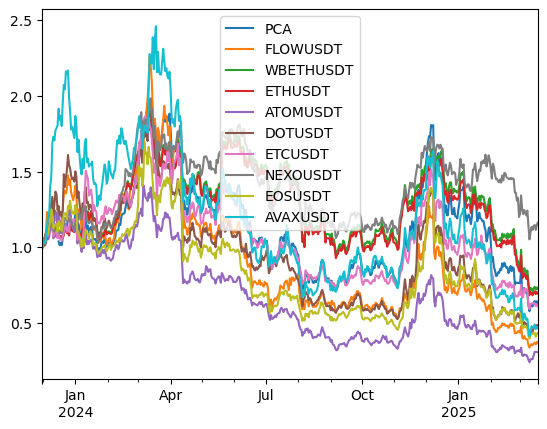

In [150]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

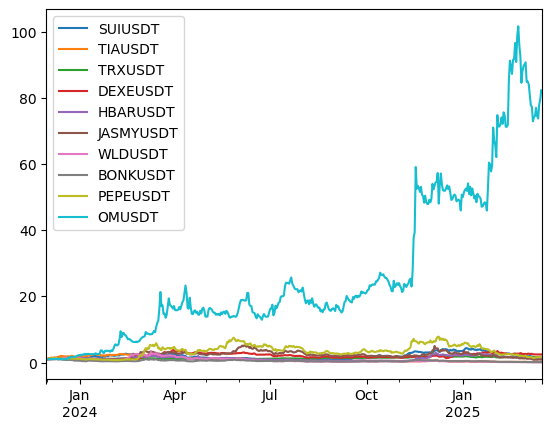

In [151]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [153]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59726628, 0.14075884, 0.10891786, 0.08836368, 0.06469334])

In [154]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.088275
BTCUSDT      0.061223
SOLUSDT      0.108104
JASMYUSDT    0.172664
ETHUSDT      0.089054
TRXUSDT      0.051064
BBUSDT       0.197878
BNBUSDT      0.065682
PEPEUSDT     0.163227
PAXGUSDT     0.002830
Name: PC1, dtype: float64

<Axes: >

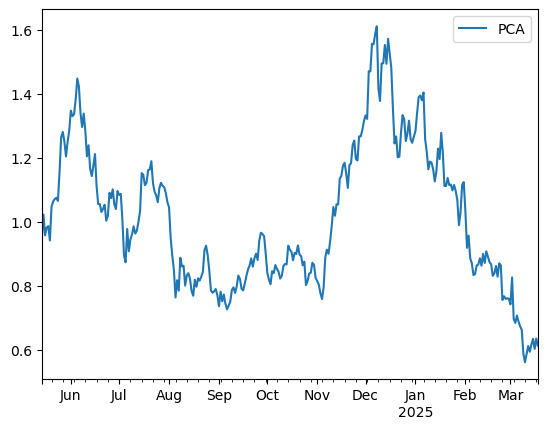

In [155]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

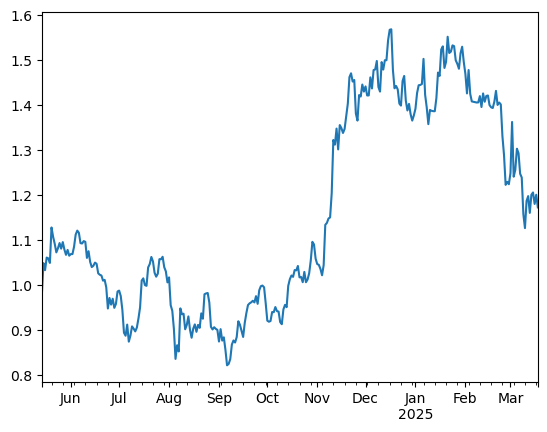

In [156]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [157]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.450036
BNBUSDT      0.507564
BTCUSDT      0.515474
SOLUSDT      0.526974
JASMYUSDT    0.706969
PEPEUSDT     0.760969
PAXGUSDT     0.782665
BBUSDT       0.807204
TRXUSDT      0.947765
dtype: float64

<Axes: >

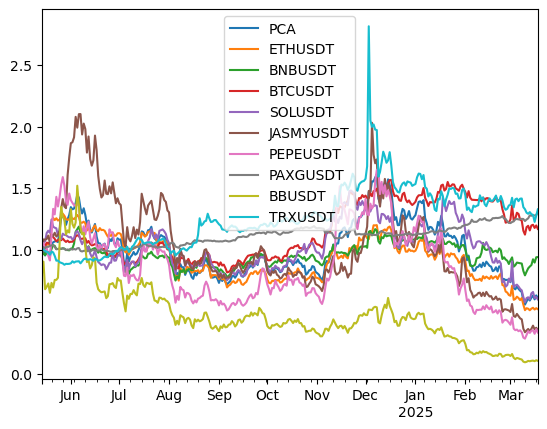

In [158]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [160]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.882613
BBUSDT       1.581152
JASMYUSDT    1.380063
SOLUSDT      1.240727
ETHUSDT      1.012332
BTCUSDT      1.000000
OMUSDT       0.875110
BNBUSDT      0.668689
TRXUSDT      0.339886
PAXGUSDT     0.037069
Name: BTCUSDT, dtype: float64

In [161]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT      1.841129
PEPEUSDT     1.653930
JASMYUSDT    1.590377
BBUSDT       1.379586
ETHUSDT      1.304073
BTCUSDT      1.000000
BNBUSDT      0.674703
OMUSDT       0.631537
TRXUSDT      0.413997
PAXGUSDT     0.024616
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [163]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [164]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BNBUSDT,0.234664
ETHUSDT,0.203274
BTCUSDT,0.178454
BBUSDT,0.163331
JASMYUSDT,0.138829
SOLUSDT,0.098321
PEPEUSDT,0.077090
TRXUSDT,0.065137
OMUSDT,-0.068252
PAXGUSDT,-0.250344


### Regression to PCA

In [166]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.045550931372598

In [167]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.298971
BNBUSDT      1.162895
ETHUSDT      1.000659
PCA          1.000000
PAXGUSDT     0.731071
SOLUSDT      0.709490
JASMYUSDT    0.471419
PEPEUSDT     0.438654
BBUSDT       0.408984
TRXUSDT      0.285960
OMUSDT       0.250019
dtype: float64

In [168]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.409669
BTCUSDT      1.339868
TRXUSDT      1.093448
PCA          1.000000
ETHUSDT      0.958302
JASMYUSDT    0.777063
BBUSDT       0.676744
SOLUSDT      0.645190
PEPEUSDT     0.642280
OMUSDT       0.638139
PAXGUSDT    -0.184682
dtype: float64

### Correlation Matrix

<Axes: >

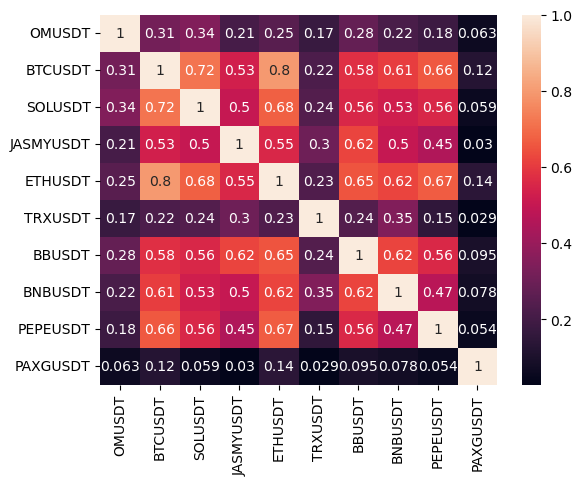

In [170]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

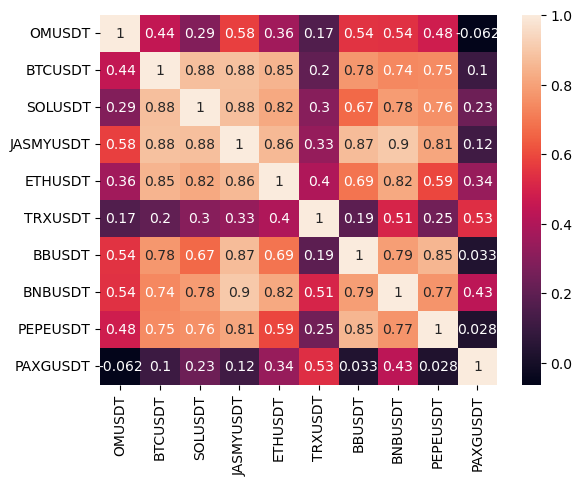

In [171]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [173]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.626168,0.000000,0.000000,0.150876,0.000000,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.019283,0.260704,0.086231,0.000000,0.000000,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.435186,0.000000,0.000000,0.000000,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.176734,0.000000,0.000000,0.000000,0.166022,0.526886,0.000000,0.000000,0.130357,0.000000


In [174]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-08-10,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.802984,0.0
2024-09-09,0.05306,0.007964,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.135553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-10-09,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.320535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-11-08,0.00000,0.008643,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-12-08,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223762,0.0
2025-01-07,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-02-06,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-08,0.00000,0.092123,0.0,0.0,0.0,0.0,0.0,0.261892,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-18,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [175]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

PAXGUSDT    0.872817
OMUSDT      0.098011
CAKEUSDT    0.027160
ADAUSDT     0.002012
SOLUSDT     0.000000
LTCUSDT     0.000000
Name: 2025-03-18 00:00:00, dtype: float64